In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as date
from datetime import timedelta
import matplotlib.pyplot as plt
from utils.api import *
from utils.price_analysis import *
from utils.utils import *
from utils.wallet_analysis import * 
from scipy import stats
# from qbstyles import mpl_style


In [2]:
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

plt.rc('figure', figsize=(8,5))
plt.rc('figure', dpi=150)
plt.rcParams['axes.grid'] = True
# mpl_style(dark=True)


#### Datasets

Our data is in three different sources:

(1) `metadata.py` stores the token names, airdrop dates, allocation sizes, and elligibility types. We reference an elligibility type of 0 as "widespread" and 1 as "core users". \
(2) `/wallet-data` has a corresponding csv file for each token (names are all coingecko ids) with wallet data on each recipient of the airdrop. Each table has a recipient address, the timestamp for their first claim, the amount claimed in total, how many transactions they used to claim, the amount they sold, and the amount they bought. \
(3) `/price-data` stores market data 60 days after TGE for each token. The structure and naming convention is identical to (2). 

We pull all of these sources in as objects. 

In [3]:
from metadata import metadata
all_token_ids = metadata.keys()
wallet_data = compile_directory_to_object('wallet_data')
market_data_index = compile_directory_to_object('price_data')

DescribeResult(nobs=40, minmax=(0.24, 67.0), mean=13.916, variance=286.86541435897436, skewness=1.8748235081820004, kurtosis=2.6099254053336045)


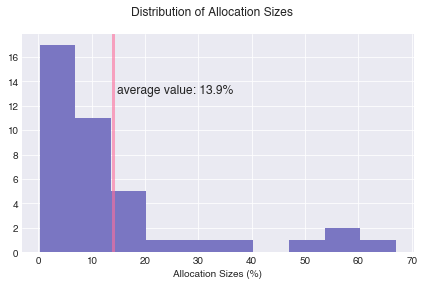

In [4]:
allocations = np.array([metadata[t]["alloc_size"] for t in metadata]) * 100
allocations.sort()
avg = allocations.mean()
print(stats.describe(allocations))

plt.hist(allocations, bins='auto') # non-normal -> use doane estimator
plt.xlabel('Allocation Sizes (%)')
plt.suptitle("Distribution of Allocation Sizes")
plt.axvline(avg, color='C1', label="Average", lw=3)
plt.text(avg + 0.8, 13, f"average value: {round(avg, 1)}%", fontsize='large')
plt.tight_layout()

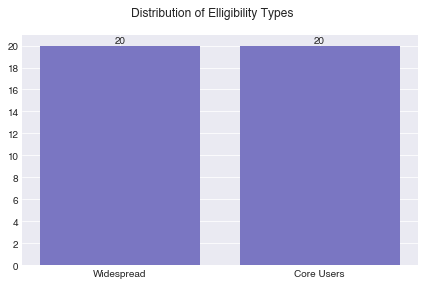

In [5]:
widespread = sum([1 for t in metadata if metadata[t]['eligibility'] == 0])
core = sum([1 for t in metadata if metadata[t]['eligibility'] == 1])


bars = plt.bar(['Widespread', 'Core Users'], [widespread, core])
plt.yticks(range(0, 21, 2))
plt.suptitle("Distribution of Elligibility Types")

for bar, value in zip(bars, [widespread, core]):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             str(value), 
             ha='center', 
             va='bottom')

plt.tight_layout()

#### Bucket Comparison

We split the data into different buckets depending on design choices.

(1) % Of Supply Airdropped. The average value of ~14% is skewed by some large outliers, so we instead use 10% as a number that we deem reasonable as a separator between "small" and "large" airdrop allocations. \
(2) Eligibility. This is a straight forward category between Widespread and Core Users.

In [6]:
# split allocation supply buckets
larger_alloc, smaller_alloc = [], []
widespread = [t for t in metadata if metadata[t]["eligibility"] == 0]
core_users = [t for t in metadata if metadata[t]["eligibility"] == 1]

for t in metadata.keys():
    if metadata[t]["alloc_size"] >= 0.1:
        larger_alloc.append(t)
    else:
        smaller_alloc.append(t)

print(f"{len(larger_alloc)} larger allocation airdrops. \n {larger_alloc}")
print(f"{len(smaller_alloc)} smaller allocation airdrops. \n {smaller_alloc}")
print("===================================================================================================")
print(f"{len(widespread)} widespread airdrops. \n {widespread}")
print(f"{len(core_users)} core user airdrops. \n {core_users}")

19 larger allocation airdrops. 
 ['jito-governance-token', 'ampleforth', 'apecoin', 'arbitrum', 'blur', 'botto', 'cow-protocol', 'dappradar', 'dydx', 'ethereum-name-service', 'forefront', 'gas-dao', 'gitcoin', 'giveth', 'looksrare', 'shapeshift-fox-token', 'uniswap', 'velodrome-finance', 'x2y2']
21 smaller allocation airdrops. 
 ['pyth-network', 'stepn', '1inch', 'arkham', 'benddao', 'ellipsis', 'forta', 'gearbox', 'hop-protocol', 'notional-finance', 'optimism', 'paladin', 'pangolin', 'pooltogether', 'project-galaxy', 'ribbon-finance', 'snowswap', 'sudoswap', 'thales', 'tornado-cash', 'value-liquidity']
20 widespread airdrops. 
 ['pyth-network', '1inch', 'blur', 'botto', 'dappradar', 'ellipsis', 'forefront', 'forta', 'gas-dao', 'gearbox', 'looksrare', 'optimism', 'paladin', 'project-galaxy', 'shapeshift-fox-token', 'sudoswap', 'thales', 'uniswap', 'velodrome-finance', 'x2y2']
20 core user airdrops. 
 ['jito-governance-token', 'stepn', 'ampleforth', 'apecoin', 'arbitrum', 'arkham', 'ben

In [22]:
# use set intersections to get our four cohorts
smaller_widespread = list(set(smaller_alloc).intersection(set(widespread)))
larger_widespread = list(set(larger_alloc).intersection(set(widespread)))
smaller_core = list(set(smaller_alloc).intersection(set(core_users)))
larger_core = list(set(larger_alloc).intersection(set(core_users)))

print(f"Smaller Alloc + Widespread \n {smaller_widespread}")
print(f"Larger Alloc + Widespread \n {larger_widespread}")
print(f"Smaller Alloc + Core Users \n {smaller_core}")
print(f"Larger Alloc + Core Users \n {larger_core}")

Smaller Alloc + Widespread 
 ['gearbox', 'forta', 'thales', 'ellipsis', 'optimism', '1inch', 'sudoswap', 'pyth-network', 'paladin', 'project-galaxy']
Larger Alloc + Widespread 
 ['velodrome-finance', 'dappradar', 'forefront', 'shapeshift-fox-token', 'uniswap', 'botto', 'gas-dao', 'looksrare', 'x2y2', 'blur']
Smaller Alloc + Core Users 
 ['hop-protocol', 'notional-finance', 'tornado-cash', 'pooltogether', 'ribbon-finance', 'arkham', 'snowswap', 'pangolin', 'stepn', 'value-liquidity', 'benddao']
Larger Alloc + Core Users 
 ['dydx', 'gitcoin', 'jito-governance-token', 'ampleforth', 'cow-protocol', 'apecoin', 'arbitrum', 'ethereum-name-service', 'giveth']


#### Price and Volatility Analysis
We look at the price performance over 15, 30, and 45 days for each set of buckets. 

In [24]:
W = 60

larger_widespread_sts = get_token_price_stats(larger_widespread, market_data_index, W)
smaller_widespread_sts = get_token_price_stats(smaller_widespread, market_data_index, W)
larger_core_sts = get_token_price_stats(larger_core, market_data_index, W)
smaller_core_sts = get_token_price_stats(smaller_core, market_data_index, W)

larger_widespread_agg = aggregrate_price_stats(larger_widespread_sts)
smaller_widespread_agg = aggregrate_price_stats(smaller_widespread_sts)
larger_core_agg = aggregrate_price_stats(larger_core_sts)
smaller_core_agg = aggregrate_price_stats(smaller_core_sts)

print(f"Widespread + Larger \n Average - Price Change: {larger_widespread_agg['avg_change']} Volatility: {larger_widespread_agg['avg_variance']}")
print(f"Median - Price Change: {larger_widespread_agg['median_change']} Volatility: {larger_widespread_agg['median_variance']}")
print("=================================================================================")
print(f"Widespread + Smaller \n Average -- Price Change: {smaller_widespread_agg['avg_change']} Volatility: {smaller_widespread_agg['avg_variance']}")
print(f"Widespread + Smaller \n Median -- Price Change: {smaller_widespread_agg['median_change']} Volatility: {smaller_widespread_agg['median_variance']}")
print("=================================================================================")
print(f"Core + Larger \n Average -- Price Change: {larger_core_agg['avg_change']} Volatility: {larger_core_agg['avg_variance']}")
print(f"Median -- Price Change: {larger_core_agg['median_change']} Volatility: {larger_core_agg['median_variance']}")

print("=================================================================================")
print(f"Core + Smaller \n Average -- Price Change: {smaller_core_agg['avg_change']} Volatility: {smaller_core_agg['avg_variance']}")
print(f"Median -- Price Change: {smaller_core_agg['median_change']} Volatility: {smaller_core_agg['median_variance']}")

Widespread + Larger 
 Average - Price Change: -0.30674816532705634 Volatility: 59.669189720034424
Median - Price Change: -0.4289242540080555 Volatility: 60.195435140409295
Widespread + Smaller 
 Average -- Price Change: -0.2019271993650872 Volatility: 31.657459758958275
Widespread + Smaller 
 Median -- Price Change: -0.35090457769295047 Volatility: 26.27592116267853
Core + Larger 
 Average -- Price Change: -0.2375908919112574 Volatility: 23.037392590182108
Median -- Price Change: -0.15720022291355712 Volatility: 22.351557520083983
Core + Smaller 
 Average -- Price Change: -0.18509005778696241 Volatility: 39.61034919074049
Median -- Price Change: -0.2945712644308604 Volatility: 37.89448605644061


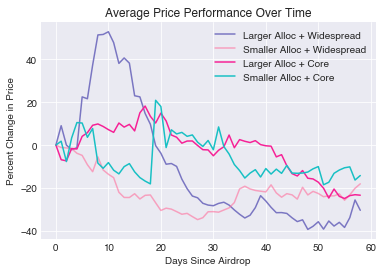

In [10]:
larger_widespread_tmseries = aggregated_time_series(larger_widespread, market_data_index, 60, 1)
smaller_widespread_tmseries = aggregated_time_series(smaller_widespread, market_data_index, 60, 1)
larger_core_tmseries = aggregated_time_series(larger_core, market_data_index, 60, 1)
smaller_core_tmseries = aggregated_time_series(smaller_core, market_data_index, 60, 1)


plt.plot([x * 100 for x in larger_widespread_tmseries["price"]])
plt.plot([x * 100 for x in smaller_widespread_tmseries["price"]])
plt.plot([x * 100 for x in larger_core_tmseries["price"]])
plt.plot([x * 100 for x in smaller_core_tmseries["price"]])

plt.title("Average Price Performance Over Time")
plt.xlabel("Days Since Airdrop")
plt.ylabel("Percent Change in Price")

plt.legend(["Larger Alloc + Widespread", 'Smaller Alloc + Widespread','Larger Alloc + Core', 'Smaller Alloc + Core'])

#### Wallet Analysis
For each of the buckets, we analyze the actions of airdrop recipients 30 days after claim. We are interested in whether or not users held, sold, or bought more of the token after receiving the airdrop. 

Additionally, we further split the analysis on quartiles of amounts claimed. Is there a difference in actions between the top and bottom 25% of airdrop claimants?

In [12]:
holding_stats = {t:get_holding_stats(wallet_data[t]) for t in wallet_data}

In [13]:
larger_widespread_holding_sts = aggregate_holding_stats(larger_widespread, holding_stats, False)
smaller_widespread_holding_sts = aggregate_holding_stats(smaller_widespread, holding_stats, False)
larger_core_holding_sts = aggregate_holding_stats(larger_core, holding_stats, False)
smaller_core_holding_sts = aggregate_holding_stats(smaller_core, holding_stats, False)

print(larger_widespread_holding_sts)
print(smaller_widespread_holding_sts)
print(larger_core_holding_sts)
print(smaller_core_holding_sts)


{'holders': {'raw': 9.197780049817354, 'pct': 0.9197780049817352}, 'buyers': {'raw': 0.048886822795851555, 'pct': 0.004888682279585155}, 'sellers': {'raw': 0.7533331273867956, 'pct': 0.07533331273867955}}
{'holders': {'raw': 8.41931556634909, 'pct': 0.8419315566349089}, 'buyers': {'raw': 0.22910598349406372, 'pct': 0.022910598349406373}, 'sellers': {'raw': 1.3515784501568462, 'pct': 0.13515784501568462}}
{'holders': {'raw': 7.680355555376137, 'pct': 0.8533728394862374}, 'buyers': {'raw': 0.1274782919178949, 'pct': 0.014164254657543876}, 'sellers': {'raw': 1.192166152705969, 'pct': 0.13246290585621878}}
{'holders': {'raw': 9.35756036114473, 'pct': 0.8506873055586116}, 'buyers': {'raw': 0.9580707055074394, 'pct': 0.08709733686431266}, 'sellers': {'raw': 0.6843689333478318, 'pct': 0.06221535757707561}}
